# Homework 3 - Pakes 1986
Solutions to ECO 384k Problem set 3 at the Universtiy of Texas by Eric Schulman

In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.stats import expon #need to use scipy stats for scale
from scipy.stats import binom

## Part 1 -  Parameter Set up

The following code sets up the parameters for the model. Here we define

* $\mu$, $\sigma$ - initial mean and variance of the patents
* $\sigma$ - the base variance of $z$  
* $\gamma$ - mean for the distribution on $z$
* $\phi$ - scales up the variance of $z$ based on age
* $\delta$ - scales ra plus 1
* $\theta$ - in probability involved with getting $r_{a+1}$

In [2]:
#load data from schedule/coefficients/set up states
coef = pd.read_csv('coef.csv',index_col=0)
schedule = pd.read_csv('schedule.csv')

#set up global variables
TIME = 20
BETA = .99

SIGMA, GAMMA, PHI, DELTA, SIGMA_R, MU,THETA = coef['france']
NSIM = 200

sched_1 =  np.array(schedule['sched_1'])
sched_2 =  np.array(schedule['sched_2'])

## Part 2 - Calculating the Value function

The following code is designed to calculate the value function using backward recursion. Although I technically only need to know previous period's value function for the purposes of calculating the current period, I memoize each periods value function.

In [3]:
def interpolate(r_sim, max_r, grid, V):
    """interpolate the value function linearly 
    based on simulated draws of the state"""
    
    #find the index
    ind = (r_sim / (1.*grid) ).astype(int)
    interp = r_sim/(1.*grid) - ind
    
    #pre set indexes to avoid going out of bounds    
    max_ind = np.minimum(np.maximum(ind,0),max_r/grid-1)
    min_ind = np.minimum(np.maximum(ind-1,0),max_r/grid-1)
    
    #interpolate EV for each simulation
    V_prev = V[0].reshape(1,len(V[0]))
    V_prev = np.tile(V_prev,(NSIM,1))
    
    V_sim = (interp)*V_prev[0][max_ind] + (1-interp)*V_prev[0][min_ind]
    
    return V_sim.mean()


def memoize_value(sched, l, max_r, grid):
    """memioze the value funcion l periods into the past"""
    
    #set up states
    states = np.array(range(0,max_r,grid))
    
    if l == TIME: #if we are in the last period
        V = [np.maximum( 0, states - sched[l-2])]
        return np.array(V)
        
    elif l >= 2 and l < 20:
        
        #calculate the value function this period
        V = memoize_value(sched,l+1,max_r, grid)
        
        EV_next = []
    
        for ra in states:
            
            #caclulate value of innovation 'z' for each state in each simulation
            sigma_l = SIGMA * PHI**(l-1)
            z_sim = expon(loc = -GAMMA, scale= sigma_l ).rvs(size=NSIM)
            
            #simulate r_a in the next period
            ra_next = np.maximum( DELTA*ra ,z_sim)
            
            #cannot figure out how to draw from K different binomials...
            binomial_pr = 1 - np.exp(-THETA*ra)
            binomial_draws = np.random.binomial(1, binomial_pr, NSIM)
            ra_next = binomial_draws*ra_next
            
            #calculate the simulated value by looping over simulations
            EV_ra_next = interpolate(ra_next , max_r, grid, V)
            EV_next.append(EV_ra_next)

        #cast to np array
        EV_next = np.array([EV_next])
        
        #calculate the value funciton this period, uisn g
        V_update = np.maximum( 0, states + BETA*EV_next - sched[l-2])
        
        #print V_update
        
        V = np.concatenate( (V_update , V), axis=0)

        return V
    else:
        print 'Index out of Bounds'
        return None

In [4]:
def value_function(r,sched,l, max_r, grid):
    """calculate the value function l periods into the
    future for current value r"""
    r = np.float32(r)
    if l > 0 and l <=20 and r >= 0 and r <= max_r:
        V = memoize_value(sched,l+1)
        return interpolate(np.array([r]), max_r, grid, V)
    else:
        print 'value out of range'

        
def find_cutoffs(V):
    """find the sequence of cutoff values"""
    cutoffs = []
    
    for l in range(len(V)):
        for r in range(len(V[l])):
            if V[l][r] > 0:
                cutoffs.append((r)*GRID)
                break
    return cutoffs

## Part 3 - Value Function and Optimal Schedule

Below I calculate the value function and cutoffs for the various schedules using France's parameters. Note that for low $r_{a}$ in the initial period, the value function is more prone to simulation error. This is because the future value can change based on the value of the simulated binomial draws for $r_{a+1}$. Getting a value of 0 is more impactful in these early stages

### Section 1 - Linear Fee Schedule

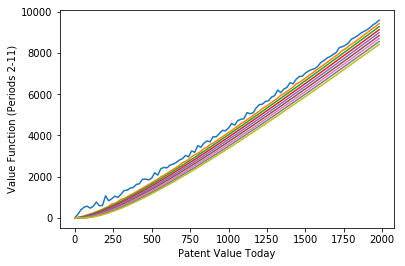

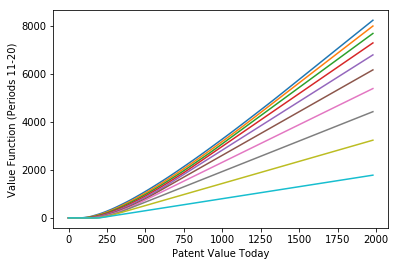

In [5]:
SCHED =  np.array(schedule['sched_1'])
MAX_R = 2000
GRID = 20
STATES = np.array(range(0,MAX_R,GRID))

#graph value function - Schedule 1
V =  memoize_value(sched_1,2,MAX_R,GRID)

#period's 1-9
fig = plt.figure()
for i in range(9):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 2-11)')

#periods 9-18
fig = plt.figure()
for i in range(9,19):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 11-20)');

Cutoff Vales: [20, 20, 20, 20, 40, 40, 60, 80, 80, 100, 120, 120, 140, 140, 160, 180, 180, 200, 220]


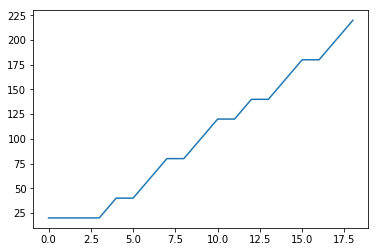

In [6]:
#graph cutoffs function - Schedule 1
cutoffs = find_cutoffs(V)
print 'Cutoff Vales: %s'%cutoffs
plt.plot(cutoffs);

### Section 2 - Linear Fee Schedule, 'Experimentation'

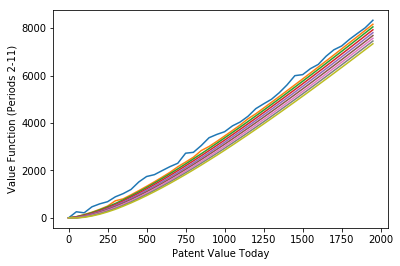

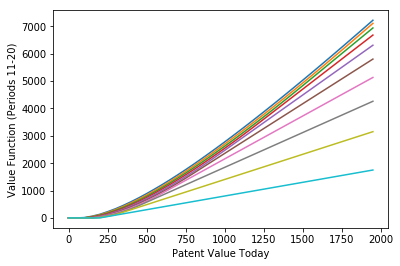

In [7]:
SCHED =  np.array(schedule['sched_1'])
MAX_R = 2000
GRID = 50
STATES = np.array(range(0,MAX_R,GRID))

#graph value function - Schedule 1
V =  memoize_value(sched_1,2,MAX_R,GRID)

#period's 1-9
fig = plt.figure()
for i in range(9):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 2-11)')

#periods 9-18
fig = plt.figure()
for i in range(9,19):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 11-20)');

### Section 3 - Quadratic fee Schedule

Below I calculate the value function and cutoffs for the second schedule using France's parameters

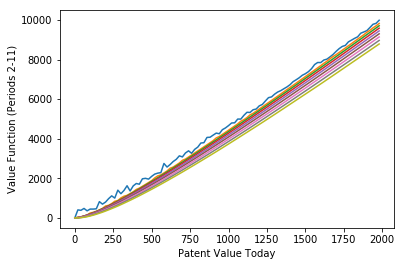

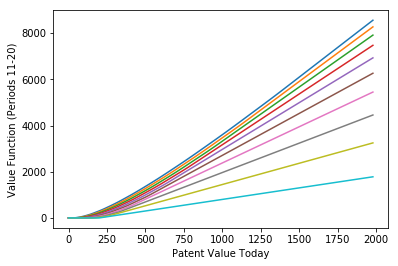

In [8]:
#graph cutoffs function - Schedule 2
SCHED =  np.array(schedule['sched_1'])
MAX_R = 2000
GRID = 20
STATES = np.array(range(0,MAX_R,GRID))

#graph value function - Schedule 1
V =  memoize_value(sched_2,2,MAX_R,GRID)

#period's 1-9
fig = plt.figure()
for i in range(9):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 2-11)')

#periods 9-18
fig = plt.figure()
for i in range(9,19):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 11-20)');

Cutoff Vales: [20, 20, 20, 20, 20, 20, 20, 20, 40, 40, 60, 80, 80, 100, 120, 140, 160, 180, 220]


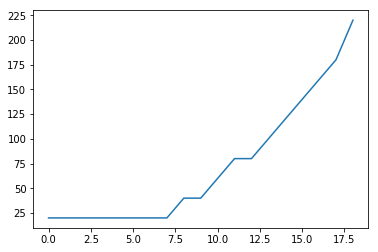

In [9]:
#graph cutoffs function - Schedule 2
cutoffs = find_cutoffs(V)
print 'Cutoff Vales: %s'%cutoffs
plt.plot(cutoffs);

## Section 4 - Comparing Results


We can see that the non-linear fee schedule results in a non-linear graph when compared to the linear fee schedule.